# Calibration scores

Confidence is estimated using MC dropout, by taking mean softmax output of all n dropout runs.

Calibration plots show the fraction of true positives within all predictions in a certain confidence bin. The histogram shows the amount of predictions in confidence bins. These plots are generated for both per-vertex and per-cluster values. Per-cluster confidences are the mean of confidence values within one cluster.

The expected calibration error is the absolute differences of per-bin frequencies and confidences, weighted by the number of predictions in each bin. Lower is better, 0 is best. 

These scores are inspired from https://arxiv.org/pdf/1911.13273.pdf


NOTES:
- with new sigmoid parameters confidence without dropout is well calibrated
- could tune dropout parameter on trainval & confirm on test (?)
- per-cluster confidences that look only at confidences high-saliency vertices are even better calibrated

In [ ]:
from meld_graph.evaluation import load_prediction, Evaluator
from meld_graph.experiment import Experiment
from meld_graph.dataset import GraphDataset
import meld_graph.confidence
import h5py
from meld_classifier.meld_cohort import MeldCohort, MeldSubject
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## evaluate model with MC dropout

run 
```
python calculate_dropout_confidence.py --model_path '/experiments_graph/co-spit1/23-08-30_IGKW_object_save_final/s_0/fold_all' --split test --model_name ensemble_best_model.pt --p 0.8 --n 10
```

## Load data for calibration plots

In [ ]:
# model paths
model_path = 'experiments_graph/kw350/23-10-30_LVHZ_dcp/s_0/fold_all_newthreshold'
model_name = 'best_model'
split = 'test'

# set suffix for correct loading & saving of files
suffix = ""
if split == "trainval":
    suffix = "_trainval"

# load experiment
exp = Experiment.from_folder(model_path)
features = exp.data_parameters['features']
cohort = exp.cohort

# load evaluator with small dataset (don't need this dataset, but want to keep loading time down)
train_ids, val_ids, test_ids = exp.get_train_val_test_ids()
dataset = GraphDataset(test_ids[:1], exp.cohort, exp.data_parameters, mode="test")
eva = Evaluator(exp, dataset=dataset, model_name=model_name, thresh_and_clust=True)  
# thresh_and_clust flag needed such that loads sigmoid parameters from file

# get subjects
if split == 'trainval':
    subjects = exp.data_parameters['train_ids'] + exp.data_parameters['val_ids']
else:
    subjects = exp.data_parameters[f'{split}_ids']
print(len(subjects))

In [3]:
# check how many subject are in prediction file that we want to use below
prediction_fname = os.path.join(model_path, f'results_{model_name}/predictions.hdf5')


In [4]:
prediction_suffix = confidence_suffix = suffix

# per vertex confidence
results_dict = meld_graph.confidence.get_confidence(eva, subjects, cohort, prediction_suffix=prediction_suffix, confidence_suffix=confidence_suffix)

#results_df_saliency = meld_graph.confidence.calculate_per_cluster_confidence(results_dict, aggregation_fn='max', mask_by_saliency=True, eva=eva, prediction_suffix=prediction_suffix)
#per_cluster_confidence, per_cluster_label = np.array(results_df_saliency['confidence']), np.array(results_df_saliency['TP'])

# fig2 = meld_graph.confidence.confidence_label_distplot(per_cluster_confidence, per_cluster_label)
# fig3 = meld_graph.confidence.cluster_calibration_plot(per_cluster_confidence, per_cluster_label)


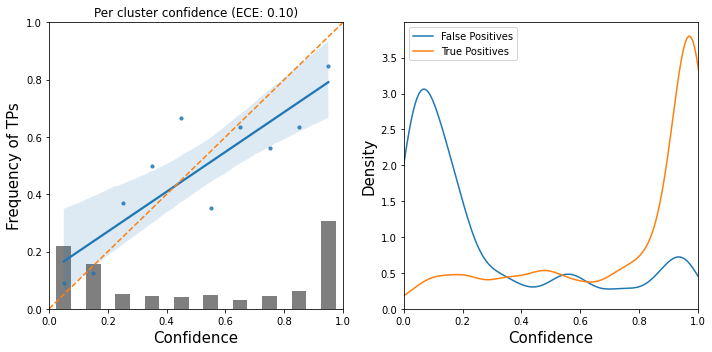

In [10]:
results_df_saliency = meld_graph.confidence.calculate_per_cluster_confidence(results_dict, 
aggregation_fn='max', mask_by_saliency=True, eva=eva, prediction_suffix=prediction_suffix)
per_cluster_confidence, per_cluster_label = np.array(results_df_saliency['confidence']), np.array(results_df_saliency['TP'])

fig,axes = plt.subplots(1,2, figsize=(10,5))
axes[1] = meld_graph.confidence.confidence_label_distplot(per_cluster_confidence, per_cluster_label,ax=axes[1])
axes[0] = meld_graph.confidence.cluster_calibration_plot(per_cluster_confidence, per_cluster_label,ax=axes[0])

plt.tight_layout()
fig.show()
# fig.savefig('../figures/calibration.png')

In [6]:
## plot IOU in function of confidence

def get_IOU_cluster(clusters_dict, results_dict):
    ''' assume that calculate_per_cluster_confidence has been run '''
    iou = []
    for i, cluster in enumerate(clusters_dict['cluster_id']):
        subj = clusters_dict['subject_id'][i]
        mask = results_dict[subj]['clusters'] == cluster
        lesion = results_dict[subj]['lesion']
        iou.append(np.logical_and(mask, lesion).sum() / (np.logical_or(mask, lesion)).sum())
    clusters_dict['IOU'] = iou
    return clusters_dict


results_df_iou = get_IOU_cluster(results_df_saliency, results_dict)
results_df_iou.head()

,subject_id,cluster_id,confidence,TP,IOU
0,MELD_H2_15T_FCD_0003,1,0.090316,1,0.162996
1,MELD_H2_15T_FCD_0003,2,0.024167,0,0.000000
2,MELD_H2_15T_FCD_0005,1,0.245754,0,0.000000
3,MELD_H2_15T_FCD_0005,2,0.010955,0,0.000000
4,MELD_H2_15T_FCD_0007,1,0.999327,1,0.332418


SignificanceResult(statistic=0.5232885754616492, pvalue=2.8924971709208993e-13)


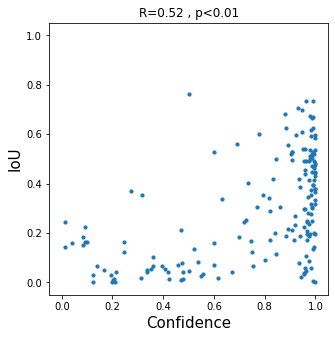

In [9]:
import scipy.stats as stats

#only look at detected
subdf = results_df_iou[results_df_iou['TP']>0].copy()

fig, axs = plt.subplots(1,1, figsize=(5,5))

plt.scatter(subdf['confidence'].values, subdf['IOU'].values, s=10)
plt.ylabel('IoU', fontsize=15)
plt.xlabel('Confidence', fontsize=15)
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

cor = stats.spearmanr(subdf['confidence'].values, subdf['IOU'].values)
if cor[1]<0.01:
    plt.title(f'R={round(cor[0],2)} , p<0.01', fontsize = 12)
else:
    plt.title(f'R={round(cor[0],2)} , p={round(cor[1],2)}', fontsize = 12)
print(cor)
